# Mapping the socio-economic situation in Mpumalanga, South Africa

In order to meet its commitments to the Paris agreements, South Africa is investigating ways to ween itself off of coal. This will be felt especially strongly in Mpumalanga, South Africa, a province in the north-east of the country between Johannesburg and Eswatini. Mpumalanga is a sparsely populated area home to most of South Africa's coal communities and coal power plants.

In [75]:
import sys, os, importlib, requests
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np
import skimage.graph as graph

from shapely.geometry import box, Point

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")

import GOSTRocks.dataMisc as dataMisc
import GOSTRocks.ntlMisc as ntlMisc
import GOSTRocks.ghslMisc as ghslMisc
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.mapMisc as mapMisc
from GOSTRocks.misc import tPrint

sys.path.insert(0, "/home/wb411133/Code/GOSTNets_Raster/src")
import GOSTNetsRaster.market_access as ma

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Define input variables 
in_folder = "/home/wb411133/projects/URB_SURDR_ZAF"
ntl_folder = os.path.join(in_folder, "NTL_data")
ghsl_folder = os.path.join(in_folder, "GHSL_data")
urban_folder = os.path.join(in_folder, "URBAN")
ma_folder = os.path.join(in_folder, "market_access")
infra_folder = os.path.join(in_folder, "Infra")
for f in [in_folder, ntl_folder, ghsl_folder, ma_folder, infra_folder]:
    if not os.path.exists(f):
        os.makedirs(f)
    
# Define global variables
global_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM0.shp"
ghs_folder = "/home/public/Data/GLOBAL/GHSL"
ghs_built_folder = os.path.join(ghs_folder, "Built")
ghs_built_files = [x for x in os.listdir(ghs_built_folder) if x.endswith(".tif")]
ghs_smod_file = os.path.join(ghs_folder, "SMOD", "GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0.tif")
ghs_ucdb = os.path.join(ghs_folder, "GHS_UCBD_R2019A", "GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
global_friction = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
global_airports_file = os.path.join(infra_folder, "airport_volume_airport_locations.csv")

# Define local variables
admin0_file = os.path.join(in_folder, 'ZAF_select_adm0.shp')
admin3_file = os.path.join(in_folder, "ADMIN", "admin3_geoBounds_FINAL.shp")
ghsl_thresh = 0.1
local_ghsl_file = os.path.join(in_folder, f"ghsl_combined_{int(ghsl_thresh*100)}.tif")
urban_raster     = os.path.join(urban_folder, "zaf1k_cpo20_urban.tif")
urban_raster_pop = os.path.join(urban_folder, "zaf1k_cpo20.tif")
urban_extents_file = os.path.join(urban_folder, "cpo20_urban_extents.shp")
local_ghs_smod_file = os.path.join(in_folder, "GHS_SMOD_2020.tif")
major_urban_extents = os.path.join(in_folder, "major_cities_UCDB2019.shp")
local_friction_file = os.path.join(ma_folder, "friction_2020.tif")
local_airports = os.path.join(infra_folder, "airports_ZAF_and_neighbours.geojson")
local_ports = os.path.join(infra_folder, "Ports.shp")
tourist_locations = os.path.join(infra_folder, "Kruger_EntryGates.shp")

In [19]:
# read in base data
ntl_files = dataMisc.aws_search_ntl()
admin0_bounds = gpd.read_file(global_bounds)
if not os.path.exists(admin0_file):
    zaf_bounds = admin0_bounds.loc[admin0_bounds['WB_A3'] == 'ZAF']
    zaf_bounds.to_file(admin0_file)
else:
    zaf_bounds = gpd.read_file(admin0_file)
neighbours = admin0_bounds.loc[admin0_bounds.intersects(zaf_bounds.unary_union.buffer(0.1))]
#
admin1_bounds = dataMisc.get_geoboundaries("ZAF", "ADM1")
admin2_bounds = dataMisc.get_geoboundaries("ZAF", "ADM2")
admin3_bounds = dataMisc.get_geoboundaries("ZAF", "ADM3")
focal_state = admin1_bounds.loc[admin1_bounds['shapeName'] == 'Mpumalanga']

In [ ]:
admin1_bounds.to_file(os.path.join(in_folder, "admin1_geoBounds.shp"))
admin2_bounds.to_file(os.path.join(in_folder, "admin2_geoBounds.shp"))
admin3_bounds.to_file(os.path.join(in_folder, "admin3_geoBounds.shp"))

# Clip raster datasets

In [ ]:
# Clip out nighttime lights annual images
# Mpumalanga
ntlMisc.generate_annual_composites(focal_state.unary_union, out_folder=os.path.join(ntl_folder, "Mpumalanga"))
# ZAF
#ntlMisc.generate_annual_composites(zaf_bounds.unary_union, out_folder=os.path.join(ntl_folder, "ZAF"))
# Neighbours
#ntlMisc.generate_annual_composites(neighbours.unary_union, out_folder=os.path.join(ntl_folder, "Neighbours"))


In [ ]:
# Clip out GHSL layers
for cur_raster_file in ghs_built_files:
    out_file = os.path.join(ghsl_folder, os.path.basename(cur_raster_file))
    if not os.path.exists(out_file):
        rMisc.clipRaster(rasterio.open(os.path.join(ghs_built_folder, cur_raster_file)), zaf_bounds, out_file, crop=False)
        tPrint(out_file)
        
# Combine GHSL layers into single file
ghsl_files = sorted([os.path.join(ghsl_folder, x) for x in os.listdir(ghsl_folder) if x.endswith(".tif")])
if not os.path.exists(local_ghsl_file):
    ghsl_res = ghslMisc.combine_ghsl_annual(ghsl_files, built_thresh=ghsl_thresh, out_file=out_file)

In [ ]:
# clip out GHS-SMOD data
if not os.path.exists(local_ghs_smod_file):
    rMisc.clipRaster(rasterio.open(ghs_smod_file), neighbours, local_ghs_smod_file, crop=False)

In [ ]:
# Convert urban centres from the constrained world_pop 2020 dataset to vector
if not os.path.exists(urban_extents_file):
    urban_extents = rMisc.vectorize_raster(rasterio.open(urban_raster), bad_vals=[0])
    urban_extents['geometry'] = urban_extents['geometry'].apply(lambda x: x.buffer(0))

    #Attribute with population
    res = rMisc.zonalStats(urban_extents, urban_raster_pop, minVal=0)
    res = pd.DataFrame(res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])
    urban_extents['Pop2020'] = res['SUM']
    urban_extents.to_file(urban_extents_file)

In [ ]:
# Extract major settlements from UCDB
if not os.path.exists(major_urban_extents):
    all_extents = gpd.read_file(ghs_ucdb)
    sel_extents = all_extents.loc[all_extents.intersects(box(*neighbours.total_bounds))]
    sel_extents.to_file(major_urban_extents)                                                     

In [ ]:
all_extents.head()

# Extract international airports

In [14]:
if not os.path.exists(local_airports):
    inA = pd.read_csv(global_airports_file)
    inA_geom = [Point(x) for x in zip(inA['Airport1Longitude'], inA['Airport1Latitude'])]
    inA = gpd.GeoDataFrame(inA, geometry=inA_geom, crs=4326)
    selA = inA.loc[inA.intersects(neighbours.unary_union)]
    selA.to_file(local_airports, driver="GeoJSON")
    
"""headers = {'Accept': 'application/json'}
ddh_international_airports = "https://wiki.worldbank.org/pages/viewpage.action?spaceKey=GEOS&title=Guide+to+procurement+of+satellite+imagery+and+derived+products"
ddh_r = requests.get(ddh_international_airports, headers=headers)
ddh_r.json()"""

# Market access

In [26]:
if not os.path.exists(local_friction_file):
    rMisc.clipRaster(rasterio.open(global_friction), neighbours, local_friction_file, crop=False)

friction = rasterio.open(local_friction_file)
frictionD = friction.read()[0,:,:] * 1000
mcp = graph.MCP_Geometric(frictionD)

In [ ]:
# Measure access to all major cities in ucdb
tt_major_cities = os.path.join(ma_folder, "tt_major_cities.tif")
if not os.path.exists(tt_major_cities):
    dests = gpd.read_file(major_urban_extents)
    dests['geometry'] = dests['geometry'].apply(lambda x: x.centroid)
    travel_costs, traceback = ma.calculate_travel_time(friction, mcp, dests)
    with rasterio.open(tt_major_cities, 'w', **friction.profile.copy()) as out_tt:
        out_tt.write_band(1, travel_costs)

In [29]:
# Measure access to international airports
tt_airports = os.path.join(ma_folder, "tt_airports.tif")
if not os.path.exists(tt_airports):
    airports = gpd.read_file(local_airports)
    travel_costs, traceback = ma.calculate_travel_time(friction, mcp, airports)
    with rasterio.open(tt_airports, 'w', **friction.profile.copy()) as out_tt:
        out_tt.write_band(1, travel_costs)

In [31]:
# Measure access to international ports
tt_ports = os.path.join(ma_folder, "tt_ports.tif")
if not os.path.exists(tt_ports):
    ports = gpd.read_file(local_ports)
    travel_costs, traceback = ma.calculate_travel_time(friction, mcp, ports)
    with rasterio.open(tt_ports, 'w', **friction.profile.copy()) as out_tt:
        out_tt.write_band(1, travel_costs)

In [34]:
# Measure access to international ports
tt_ports = os.path.join(ma_folder, "tt_tourism.tif")
if not os.path.exists(tt_ports):
    ports = gpd.read_file(tourist_locations)
    travel_costs, traceback = ma.calculate_travel_time(friction, mcp, ports)
    with rasterio.open(tt_ports, 'w', **friction.profile.copy()) as out_tt:
        out_tt.write_band(1, travel_costs)


In [65]:
dests = gpd.read_file(admin3_file)
dests['geometry'] = dests['geometry'].apply(lambda x: x.centroid)

od_res = ma.calculate_od_matrix(friction, mcp, dests)
final_od = pd.DataFrame(od_res)
final_od.to_csv(os.path.join(ma_folder, "admins3_od.csv"))

14:49:12	Starting 0
14:49:20	Starting 1
14:49:28	Starting 2
14:49:36	Starting 3
14:49:44	Starting 4
14:49:53	Starting 5
14:50:01	Starting 6
14:50:10	Starting 7
14:50:18	Starting 8
14:50:26	Starting 9
14:50:35	Starting 10
14:50:43	Starting 11
14:50:51	Starting 12
14:50:59	Starting 13
14:51:07	Starting 14
14:51:15	Starting 15
14:51:24	Starting 16
14:51:32	Starting 17
14:51:40	Starting 18
14:51:48	Starting 19
14:51:56	Starting 20
14:52:04	Starting 21
14:52:12	Starting 22
14:52:20	Starting 23
14:52:28	Starting 24
14:52:37	Starting 25
14:52:45	Starting 26
14:52:53	Starting 27
14:53:01	Starting 28
14:53:09	Starting 29
14:53:17	Starting 30
14:53:25	Starting 31
14:53:33	Starting 32
14:53:41	Starting 33
14:53:50	Starting 34
14:53:58	Starting 35
14:54:06	Starting 36
14:54:14	Starting 37
14:54:22	Starting 38
14:54:30	Starting 39
14:54:38	Starting 40
14:54:46	Starting 41
14:54:54	Starting 42
14:55:02	Starting 43
14:55:11	Starting 44
14:55:19	Starting 45
14:55:27	Starting 46
14:55:35	Starting 47
14

In [69]:
# calculate total population and nighttime lights brightness for each admin3
dests = gpd.read_file(admin3_file)
pop_res = rMisc.zonalStats(dests, urban_raster_pop, minVal=0, reProj=True)
pop_res = pd.DataFrame(pop_res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])
pop_res

In [73]:
ntl_raster = os.path.join(ntl_folder, "Neighbours", "VIIRS_2022_annual.tif")
ntl_res = rMisc.zonalStats(dests, ntl_raster, minVal=1, reProj=True)
ntl_res = pd.DataFrame(ntl_res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])

In [79]:
mapMisc.static_map_vector?

<module 'matplotlib.pyplot' from '/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/matplotlib/pyplot.py'>

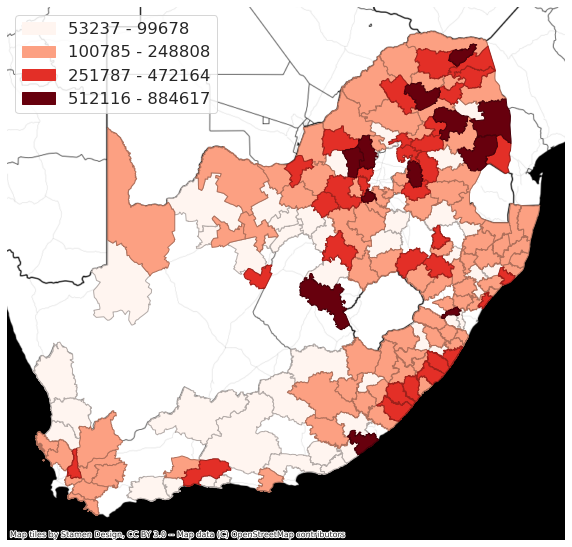

In [83]:
dests['Pop'] = pop_res['SUM']
dests['NTL'] = pop_res['SUM']
mapMisc.static_map_vector(dests, "Pop", legend_loc="upper left", thresh=[50000, 100000, 250000, 500000, 1000000])

# Debugging